# Bayesian Modeling with rstan

Bayesian data analysis is a subset of statistial methods that utilize Bayes' theorem, which describes the probability of an event based on knowledge or conditions related to that event.

$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$

Nothing is controversial about this mathematical formulation; it's derived from the law of conditional probability.

$P(A \text{ and } B) = P(A|B)P(B) = P(B|A)P(A)$

In the context of Bayesian data analysis, however, we attach special terms to these objects. $P(A|B)$ is the posterior distribution of $A$, given $B.$ $P(B|A)$ is known as the likelihood, and is derived from the data, and $P(B)$ is known as the prior. In practice, these quantities are easy to calculate from the data, however the denominator requires a bit of thought. $P(B)$ is equal to $P(B|A)P(A) + P(B|A')P(A')$, where $A'$ means not $A$.

$P(A|B) = \frac{P(B|A)P(A)}{P(B|A)P(A) + P(B|A')P(A')}$

When modeling data, we're interested in the likelihood of the data given certain parameters, such as the mean and standard deviation of a normal distribution. We can write:

$f(\theta|y) = \frac{f(y|\theta)f(\theta)}{f(y)}$

where the functions represent probability distributions. $f(y)$ is a normalizing constant we calculate as $\int f(y|\theta) f(\theta) ~d \theta$, called the marginal likelihood. We use an integral instead of a sum because many probability distributions are continuous functions rather than discrete. A challenge with Bayesian analysis historically has been that this integral is intractable unless the posterior distribution has a conjugate prior, in which the prior and likelihood combine such that the prior and posterior are of the same family. For example, when the prior is Beta-distributed and the likelihood is Bernoulli, then the posterior is an analytically calculable Beta distribution. Nowadays, approximation methods have advanced to the point where we care much less about conjugate priors, but for applications such as real-time computation, they are still necessary. Approximation methods rely on rejection sampling, based on the likelihood of each guess given the data, and have become very sophisticated. Luckily for the practitioner, they can largely treated as a black-box inference button.


# The Prior Distribution

So how do we determine this prior distribution involved in the calculation? If we were testing for a rare disease given a positive test $P(A|B)$, and the probability of the test being positive given the disease $P(B|A)$ is $98\%$, then the posterior is $P(A|B)$, the likelihood is $98\%$, and the prior $P(A)$ is simply the proportion of the population who has the disease. This is a simple application of Bayes' rule.

Extended to probability distributions and data analysis, this 'prior' variable has been used to specify prior or expert knowledge, which integrates such information using defensible theory, but has rightfully been suspected of allowing researchers to sneak in extra degrees of freedom. Are we being subjective rather than objective if we use prior or expert information? Is it inappropriate to peek at the data? The answer is subjective, so I'll largely speak through the words of others, but to describe how would select a prior, it helps to explain why.

To start, and sticking with the traditional definitions of objectivity and subjectivity (there is an interesting **paper** from Andrew Gelman exploring the semantics), one can ask, is it truly objective not to include prior or expert information about the population, if relevant in the context of your experiment? If the the sample size is small and the sampling variance high, is it wrong to help out the model? And if the sample size is large, is it perhaps more appropriate to ask finer-grained questions (**link**)?

This speaks toward what is known as the reproducibility crisis. In sciences where sample size of an experiment is a challenge, researchers often struggle to reproduce the results of past literature. A prior distribution allows one to incorporate prior/expert information about the population which may be necessary in order to regularize results.

Another example of the benefit of Bayesian updating is sequential updating. Looking retrospectively at a 30-day time-series, it's relatively easy to fit a distribution to the data, but how would you have inferred the parameters as the data was trickling in? You would do well to define a prior distribution of reasonable parameters and acquire a new distribution through Bayesian updating with each data point. The nature of this is such that the result after 30 days would match the result of pooling the data retroactively, aside from the influence of the prior, which decays as the number of data points grows larger.

Another popular method of incorporating Bayesian updating is with hierarchical modeling. For example, modeling the trend of a political poll at the state or province level to incorporate information about the aggregate trend in the lower-level predictions.

One last example is when suffering from 'complete separation' in a classification model such as logistic regression. Complete separation means that the class 0 and class 1 data points do not overlap at all across the predictor(s). The curve found will be something like a step function, which is intuitively unrealistic, and the incorporation of a prior distribution will help the logistic regression assume a smooth curve.

# Choosing a Prior

Some types of priors are intended to be 'objective', letting the data speak for itself. These include flat priors, i.e., a uniform distribution, and empirical priors, i.e., priors based on the data. The former is much less popular than it used to be and the latter is largely seen as double-dipping upon the likelihood.

Weakly informative priors, e.g., a normal distribution with wide variance, are generally viewed as being preferable to flat priors, and can be preferable to data-based priors if the data isn't robust. Informative priors are great when you're well-informed, i.e., your prior knowledge is robust. We often set a variance slightly larger than the data is expected to reflect, and then allow the likelihood to sharpen up those results into the posterior distribution.

In terms of default priors, zero-centering the data makes it easy to determine the mean (0) and standardizing data makes it easier to set an expectation; e.g., if the data is normally distributed, $\sigma=1$. **Andrew Gelman**, a leading author and professor in the field, has expressed a preference for N(0,1) despite the relatively short tails, though obviously it's important to adjust things where necessary. Fellow professor **Aki Vehtari**, also very well known in the field, has expressed a preference for t(3,0,1) as a default to get the analysis going, when not possessing much prior information. I have found t-distributions with larger degrees of freedom (e.g. 20) to be a sometimes necessary compromise between the two.

# Linear Models

The probabilistic specification of a single-variable linear model, with normally distributed data, is expressed:

$y \sim N(\alpha + \beta x, ~\sigma)$

meaning that the mean of the normally distributed result is equal to the intercept of the model $\alpha$ plus the sum of the x-variable coefficient $\beta$ and the value $x_i$ of the vector $x$, for each $x_i$ in $x$. Rather than solve with least squares, we can solve with Bayesian inference, which will return probability distributions over parameters rather than point estimates. The larger the size of the data, the more the mean values of these parameters will align with those found with a maximum-likelihood based method.

We could adjust this to multple regression with something like the following:

$y \sim N(\alpha + \beta_1 x_1 + \beta_2 x_2, ~\sigma)$

Or polynomial regression:

$y \sim N(\alpha + \beta_1 x_1 + \beta_2 x_1^2, ~\sigma)$

Each $y$ variable has a single intercept and standard deviation ($\sigma$), but can have multiple beta coefficients and predictor ($x$) variables. We could create arbitrarily more complex functions of the predictor variables. Also, we are not restricted to the normal distribution, as used above. We could easily switch to a t-distribution, for example, to make regression upon a predictor variable more robust to outliers (more on this later).


# Implementation

Bayesian inference relies on drawing a large number of samples from the posterior distribution, and as such, has relied on highly efficient samplers coded in low-level languages like C++. Andrew Gelman, Aki Vehtari, and others developed a package called <code>stan</code>, which can be accessed through R with the library <code>rstan</code>, or in Python with the package <code>pystan</code>. In Python, however, the more widely used package is <code>pymc</code>, which has different authors. A library called <code>bambi</code> is built upon <code>pymc</code> and makes the syntax for linear modeling more concise.

We will use <code>rstan</code>. It requires that you write <code>stan</code> code, which is in C++, and then pass that code into the R function <code>stan()</code>, passing in the list of the data to be considered by the model(s). Despite this, it's quite simple to use, and the debugging messages are quite helpful. The <code>stan</code> code contains blocks for <code>data{}</code>, <code>parameters{}</code>, <code>model{}</code>, and <code>generated quantities{}</code>. We'll go through them one by one. There are additional types of code blocks you can look into independently (<a href="https://mc-stan.org/docs/reference-manual/blocks.html#:~:text=A%20Stan%20program%20is%20organized%20into%20a%20sequence%20of%20named">user guide here)</a>, including <code>functions{}</code>, <code>transformed data</code>, <code>initialization{}</code>, <code>constraints</code>, and others.

In [103]:
# install.packages("BiocManager")
# library("BiocManager")

# BiocManager::install("bnlearn")
# BiocManager::install("Rgraphviz")
# BiocManager::install("rstan")

# BiocManager::install("GGally")
# BiocManager::install("boot")

library(bnlearn)
library(Rgraphviz)
library(rstan)
library(GGally)
library(boot)

# The Urinalysis Data

The data we'll use is from the R package <code>boot</code>, and describes the levels of various measures in a urinalysis of 79 samples, in which some variables have a conditional dependence on others. These variables include:

- <code>r</code>: Indicator of the presence of calcium oxalate crystals.
- <code>gravity</code>: Density dependent on dissolved particulates.
- <code>ph</code>: level of acidity or alkalinity
- <code>osmo</code>: osmolarity; proportional to the concentration of molecules in solution.
- <code>cond</code>: conductivity; proportional to the concentration of charged ions in solution.
- <code>urea</code>: urea concentration in millimoles per litre.
- <code>calc</code>: calcium concentration in millimoles per litre.

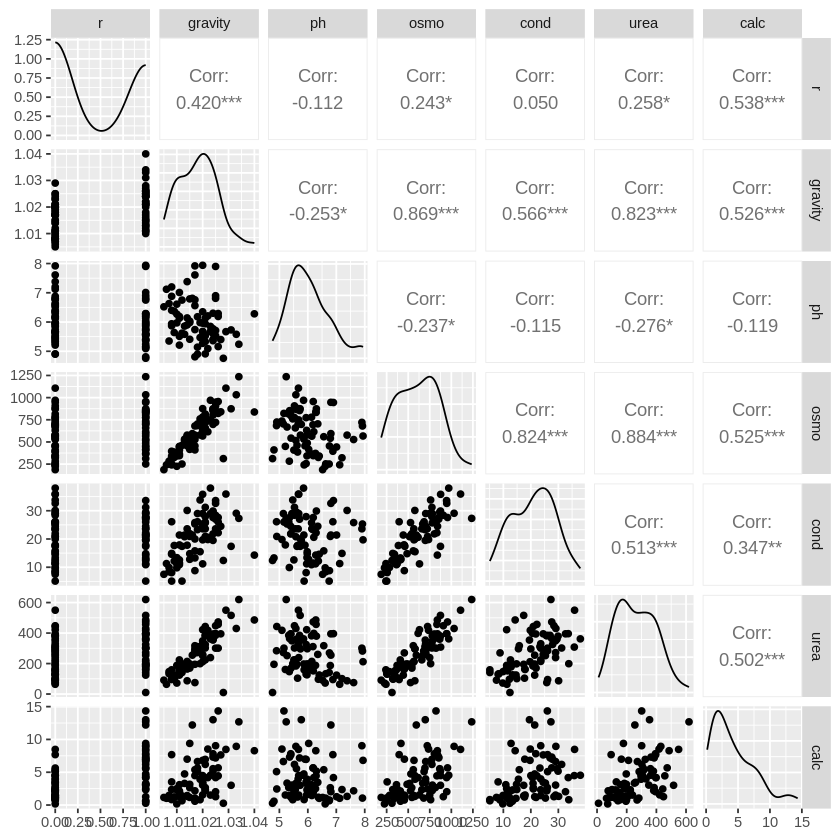

In [104]:
data <- urine

# impute a couple of missing values
data$osmo[is.na(data$osmo)] <- mean(data$osmo, na.rm = TRUE)
data$cond[is.na(data$cond)] <- mean(data$cond, na.rm = TRUE)

# pair plot
ggpairs(data)

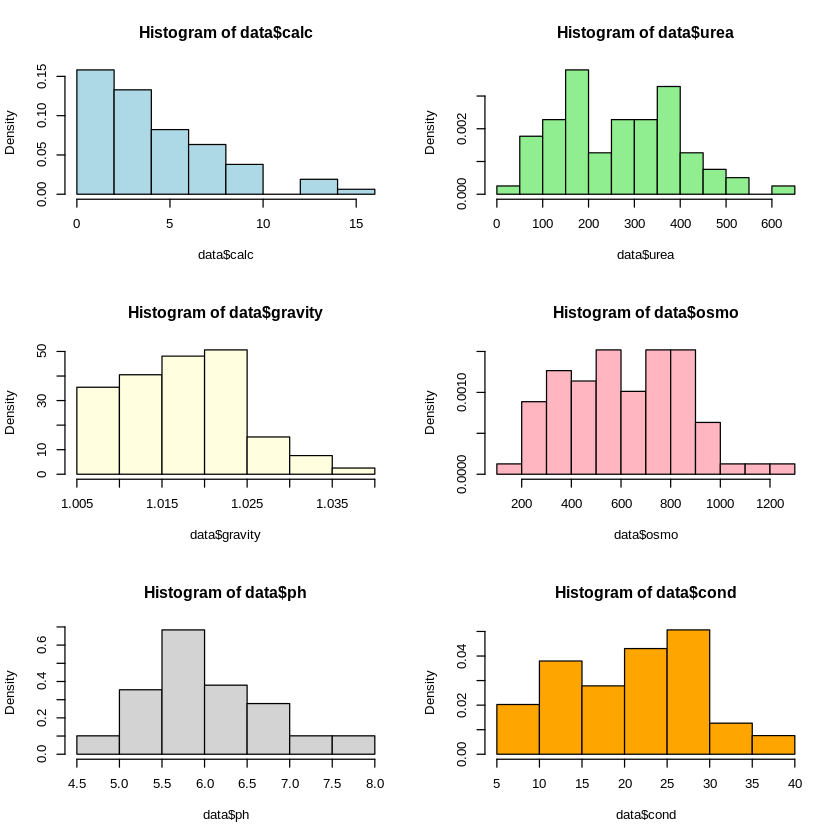

In [105]:
par(mfrow = c(3, 2))

hist(data$calc, breaks = 10, probability = TRUE, col = "lightblue", border = "black")
hist(data$urea, breaks = 10, probability = TRUE, col = "lightgreen", border = "black")
hist(data$gravity, breaks = 10, probability = TRUE, col = "lightyellow", border = "black")
hist(data$osmo, breaks = 10, probability = TRUE, col = "lightpink", border = "black")
hist(data$ph, breaks = 10, probability = TRUE, col = "lightgray", border = "black")
hist(data$cond, breaks = 10, probability = TRUE, col = "orange", border = "black")

We also have a binary variable, <code>r</code> (indicator of calcium oxalate crystals).

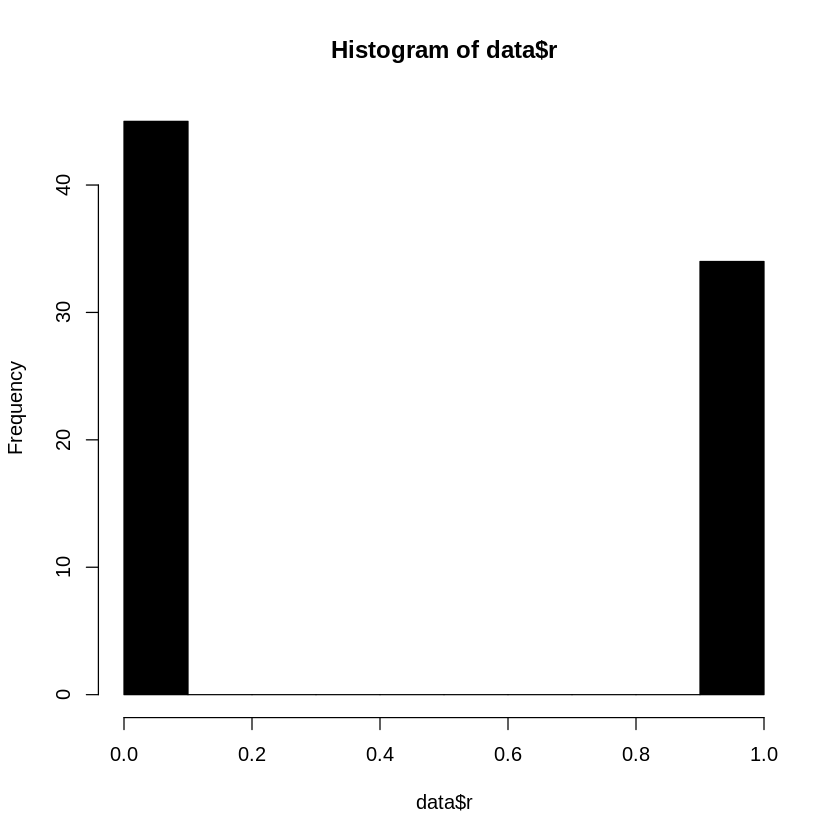

In [106]:
hist(data$r, col = "black")

# Bayesian Networks

Often, when modeling, we have some causal interpretation of the variables as a function of other variables. In our case, we know from well-established science which of these are likely to be dependent upon others. In situations where we have structure like this, or where we wish to learn the latent structure among variables, we can utilize a Bayesian network. A Bayesian network is a class of graphical model which represents variables as nodes and conditional relationships with arcs (arrows). Reasons for the term 'Bayesian' include:

- The reliance on Bayes' theorem for conditioning as the basis for updating information.
- The subjective nature of choosing the variables' structure and directions.
- The ability to incorporate prior information.

It is traditionally very common to discretize variables in a Bayesian network, for mathematical convenience. It is also convenient to use Gaussian distributions around a linear-modeled mean (one for each category in a discrete-to-continuous relationship). <code>bnlearn</code> is a robust package of functions for creating and working with Bayesian networks in R, and is very convenient to work with when data is discrete or assumed to be Gaussian (or a mixture of both). To work with more customized distributions, we will model things more manually in <code>rstan</code>, and only use <code>bnlearn</code> to plot our directed acyclic diagram (DAG).

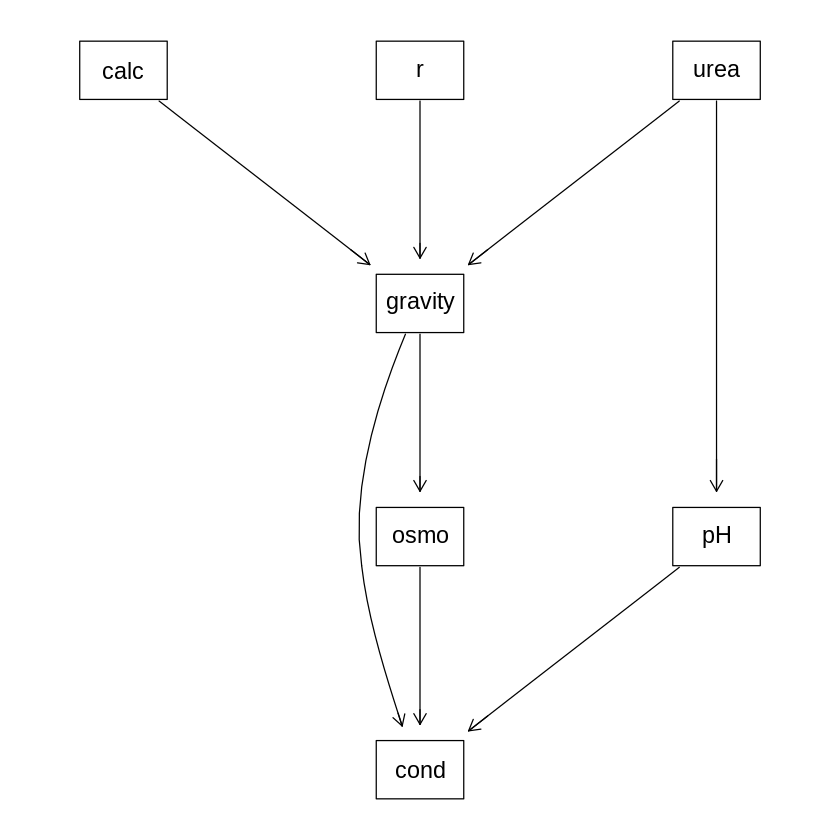

In [107]:
modelstr <- "[urea][r][calc][gravity|r:calc:urea][pH|urea][cond|gravity:osmo:pH][osmo|gravity]"
dag <- model2network(modelstr)
graphviz.plot(dag)

<code>calc</code>, <code>r</code> (presence of oxalate crystals) and <code>urea</code> all contribute to <code>gravity</code>, which measures the level of dissolved particles. <code>osmo</code> (osmotivity) depends on gravity, <code>ph</code> depends on <code>urea</code>, and <code>cond</code> (conductivity) depends on <code>gravity</code>, <code>osmo</code>, and <code>ph</code>. Of course, each of these variables also has an inherent amount of random variability. Forgive me if any of this is incorrect, I am certainly no expert; but for the sake of demonstration, this structure will suffice. If we had no prior knowledge of the relationships between variables, learning the structure from data could be accomplished through a variety of algorithms, and we can even use resampling methods in which we fit many networks, and keep the arcs that appear with a frequency greater than a particular threshold.

# Back to Implementation

Back to modeling - we discussed that the code provided to <code>stan</code> can include multiple types of code blocks. We'll explore the essential ones one by one.

The <code>data{}</code> block declares the variables to be populated with the data passed in via a list in the <code>stan()</code> function of R. At a minimum, this will typically include an <code>N</code> variable and a <code>y</code> variable, though you are free to give them any other names you want. To declare an integer number of samples, we use <code>int &ltlower=0&gt N;</code>, where <code>&ltlower=0&gt</code> is an optional argument which constrains the values of the variable to be 0 or greater. For a binary variable, we could use <code>int &ltlower=0, upper=1&gt myvar;</code>, and for a non-integer number on the real line, we would use type <code>real</code> instead of <code>int</code>. A vector with elements of type <code>real</code> may be declared as <code>vector[N] myvector;</code>, where <code>N</code> represents the number of elements, or for greater flexibility, you can create an array of the desired type with <code>N</code> elements. With a <code>vector</code>, you can take advantage of matrix-multiplication where possible, whereas with an array, you must always loop through the elements while working with it.

We'll start simple, taking the <code>gravity</code> variable and modeling it as a Gaussian with no predictor variable. Our <code>data{}</code> block will look like this:

In [108]:
# data {
#   int<lower=0> N;
#   vector[N] y;
# }

The <code>parameters{}</code> block is for declaration of non-data variables (i.e., parameters) to be used in the modeling process. For the normal distribution we will use to model the data, we will declare the parameters <code>mu</code> and <code>sigma</code> as real-numbered variables, with <code>sigma</code> bounded at $0$.

In [109]:
# parameters {
#   real mu;
#   real<lower=0> sigma;
# }

In the <code>model{}</code> block, parameters are mapped to the data to be fit. We can declare a prior distribution on these parameters, or let <code>stan</code> assign a flat prior by default. For the sake of simplicity in this first example, we will not yet set priors on the parameters.

In [110]:
# model {
#   y ~ normal(mu, sigma);
# }

Finally, the <code>generated quantities{}</code> block is where we generate predictions from the fitted model. This is optional; if you are only interested in finding parameters, the <code>model{}</code> block is all you require, and I will show you how to extract them momentarily. The variables used to store predictions corresponding to the variables in the data must be declared in this block. The predictions themselves can be calculated in vector form if the data supports it, but otherwise, a loop through each <code>n</code> in <code>N</code> is required. The differences between referring to a distribution in the <code>model{}</code> block and referring to a distribution in the <code>generated quantities{}</code> block are that 1) in the <code>model{}</code> block we use the ~ operator whereas in the <code>generated quantities{}</code> block, we use =, and 2) when using the model to generate quantites, we append it with <code>_rng</code>.

In [111]:
# generated quantities {
#   vector[N] y_pred;
#   for (n in 1:N) {
#     y_pred[n] = normal_rng(mu, sigma);
#   }
# }

Putting these elements together, we have written the C++ code for <code>stan</code>.

In [112]:
stan_code <- "
  data {
    int<lower=0> N;
    vector[N] y;
  }

  parameters {
    real mu;
    real<lower=0> sigma;
  }

  model {
    y ~ normal(mu, sigma);
  }

  generated quantities {
    vector[N] y_pred;
    for (n in 1:N) {
      y_pred[n] = normal_rng(mu, sigma);
    }
  }
"


We have saved the <code>stan</code> code for the model into a variable called <code>stan_code</code>, and will pass this in as the first argument to the R function <code>stan()</code>, which will compile the mode. We'll also pass in a list of data objects corresponding to variables declared in the <code>data{}</code> block. Additional arguments include <code>iter</code>, the number of samples to draw while fitting the model (and generating quantities); <code>warmup</code>, to discard a certain number of leading quantities in a sampling chain (as they are often of poorer quality); and <code>chains</code>, representing the number of sampling chains to perform, as it is a good practice to ensure that multiple chains converge upon similar results.

As the <code>y</code> variable in the <code>data_list</code> and <code>data{}</code> block, we will use the scaled <code>gravity</code> data. The last argument, <code>refresh</code>, is set to <code>0</code> in order to suppress the lengthy output while sampling.

In [113]:
y <- c(scale(as.vector(as.matrix(data$gravity))))

N <- nrow(data)
data_list <- list(N=N, y=y)
model_fit <- stan(model_code = stan_code, data = data_list, warmup=500,
                 iter = 2000, chains = 4, refresh = 0, cores = 4)

To extract parameter values and generated quantities from the <code>model_fit</code> variable I've used to store the returns of the <code>stan()</code> function, we run the <code>extract()</code> function upon it. Doing this and then working with the matrix of parameter and generated quantity values extracted is more efficient than calling upon the non-extracted <code>model_fit</code> object multiple times. If no <code>generated quantities{}</code> block is present in the <code>stan_code</code>, then the extract will only contain parameter values. One parameter value will be present for each draw, and the mean, standard deviation, and various quantiles will be reported to summarize them.

In [114]:
model_fit

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=6000.

             mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff Rhat
mu           0.00    0.00 0.11  -0.23  -0.07   0.00   0.08   0.22  5487    1
sigma        1.02    0.00 0.08   0.87   0.96   1.01   1.07   1.20  4538    1
y_pred[1]    0.00    0.01 1.04  -2.04  -0.70   0.00   0.69   2.04  5983    1
y_pred[2]    0.00    0.01 1.03  -2.04  -0.67   0.02   0.69   1.99  6169    1
y_pred[3]    0.00    0.01 1.02  -1.99  -0.68  -0.02   0.68   1.99  5797    1
y_pred[4]   -0.01    0.01 1.03  -2.04  -0.71  -0.02   0.67   2.03  5753    1
y_pred[5]    0.00    0.01 1.02  -2.02  -0.67  -0.01   0.68   2.06  5810    1
y_pred[6]   -0.02    0.01 1.03  -2.05  -0.72  -0.02   0.67   2.03  5716    1
y_pred[7]   -0.01    0.01 1.03  -2.05  -0.70  -0.01   0.70   1.99  6212    1
y_pred[8]   -0.01    0.01 1.03  -2.07  -0.71  -0.02   0.66   2.04  5785    

In [115]:
class(model_fit)
posterior_samples <- extract(model_fit)

[1] "stanfit"
attr(,"package")
[1] "rstan"

In [116]:
mu <- mean(posterior_samples$mu)
sigma <- mean(posterior_samples$sigma)
mu
sigma

[1] -0.00029122

[1] 1.0185

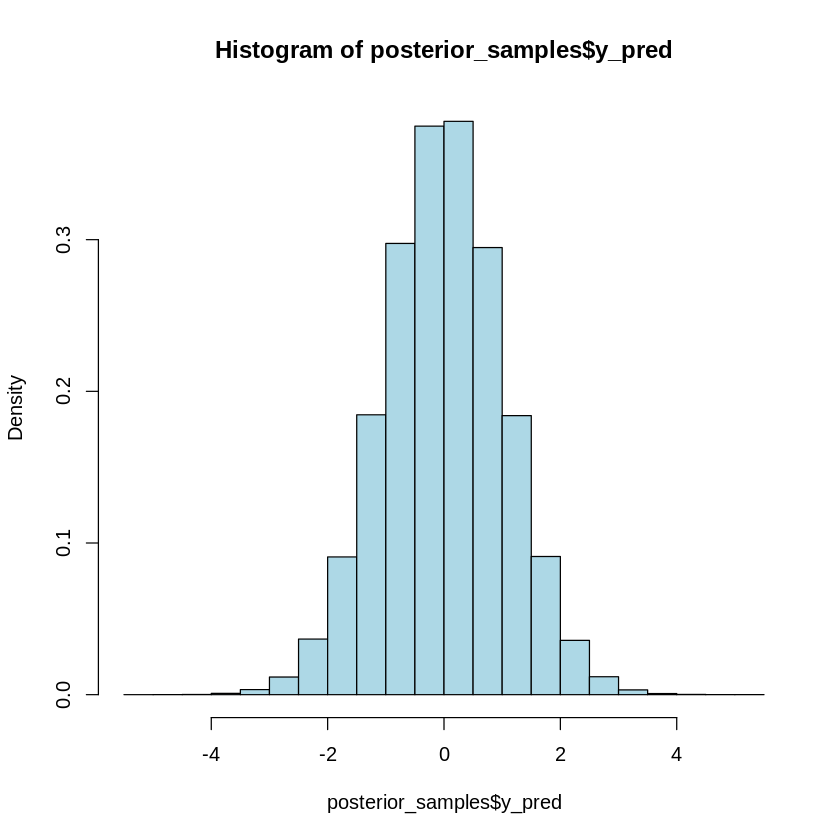

In [117]:
hist(posterior_samples$y_pred, col="lightblue", probability = TRUE)

If new data were to come in, we may wish to analyze it using the parameters found above to define the prior distribution. To do so, we modify the <code>data</code> block, <code>parameters{}</code> block, and <code>model</code> block as follows.

In [118]:
# data {
#   int<lower=0> N;
#   real prior_mu;
#   real prior_sigma;
#   vector[N] y;
# }

# parameters {
#   real mu;
#   real<lower=0> sigma;
# }

# model {
#   y ~ normal(prior_mu, prior_sigma);
# }

In [120]:
stan_code <- "
  data {
    int<lower=0> N;
    real prior_mu;
    real prior_sigma;
    vector[N] y;
  }

  parameters {
    real mu;
    real<lower=0> sigma;
  }

  model {
    y ~ normal(prior_mu, prior_sigma);
  }

  generated quantities {
    vector[N] y_pred;
    for (n in 1:N) {
      y_pred[n] = normal_rng(mu, sigma);
    }
  }
"

In [123]:
# Using the parameters found as priors upon "new" data.

In [125]:
prior_mu_mean <- mean(posterior_samples$mu)
prior_mu_sigma <- sd(posterior_samples$mu)
prior_sigma_mean <- mean(posterior_samples$sigma)
prior_sigma_sigma <- sd(posterior_samples$sigma)

prior_mu_mean
prior_mu_sigma
prior_sigma_mean
prior_sigma_sigma

[1] -0.00029122

[1] 0.11288

[1] 1.0185

[1] 0.084936

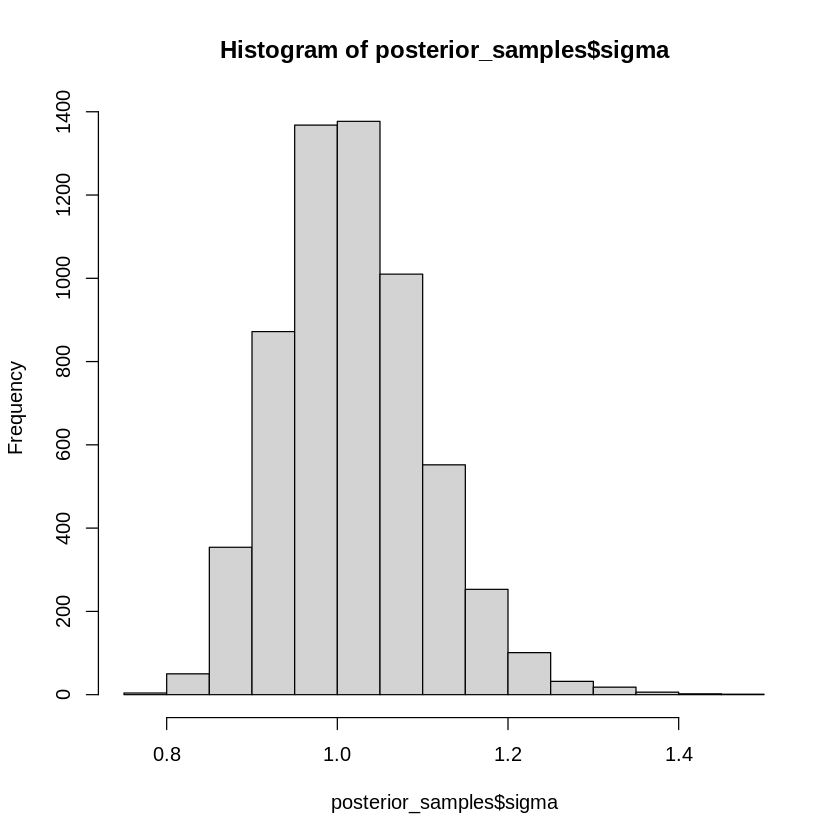

In [126]:
hist(posterior_samples$sigma)

In [127]:
stan_code <- "
  data {
    int<lower=0> N;
    vector[N] y;
    real prior_mu_mean;
    real prior_mu_sigma;
    real prior_sigma_mean;
    real prior_sigma_sigma;
  }

  parameters {
    real mu;
    real<lower=0> sigma;
  }

  model {
    mu ~ normal(prior_mu_mean, prior_mu_sigma);
    sigma ~ normal(prior_sigma_mean, prior_sigma_sigma);
    y ~ normal(mu, sigma);
  }

  generated quantities {
    vector[N] y_pred;
    for (n in 1:N) {
      y_pred[n] = normal_rng(mu, sigma);
    }
  }
"

In [129]:
y_sampled <- sample(y, 15)
N <- length(y_sampled)
data_list <- list(N = N,
                  y = y_sampled,
                  prior_mu_mean = prior_mu_mean,
                  prior_mu_sigma = prior_mu_sigma,
                  prior_sigma_mean = prior_sigma_mean,
                  prior_sigma_sigma = prior_sigma_sigma)
model_fit <- stan(model_code = stan_code, data = data_list, warmup=1000,
                 iter = 10000, chains = 4, refresh = 0, cores = 4)

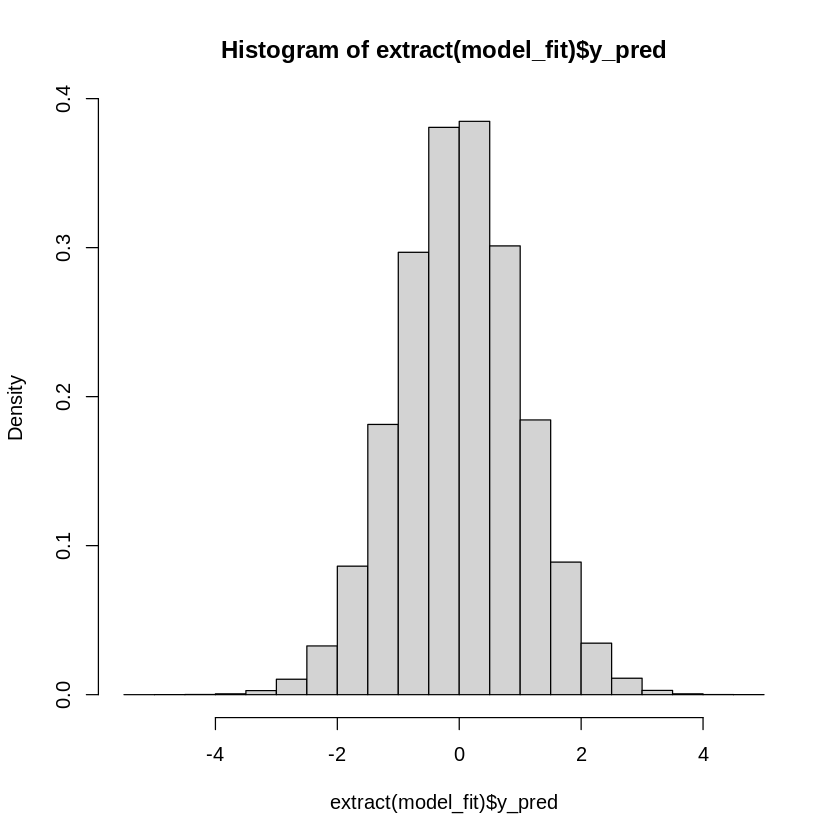

In [130]:
hist(extract(model_fit)$y_pred, probability=TRUE)

# Linear Modeling in <code>rstan</code>

Creating a linear model is not much different, except that
1) we will provide an <code>x</code> (predictor) variable, and
2) the <code>mu</code> parameter of our normal distribution will be replaced by an intercept parameter <code>alpha</code> plus a slope parameter <code>beta</code> multiplied by <code>x</code>.

Again, you may use other names if you wish, so long as the appropriate number of parameters are provided to each model (their position determines their interpretation). <a href="https://mc-stan.org/docs/2_18/functions-reference/bernoulli-distribution.html">This document</a> details the distributions available, and the parameters expected for each. In the below, we will model <code>osmo</code> as a linear function of <code>gravity</code>. To keep it simple, we'll avoid setting priors and let <code>stan</code> choose flat ones, but we will declare the parameters as being modeled by particular distributions (normals). If not for the experimentation above, I would model <code>sigma</code> with a distribution that is strictly positive, however I've seen that the variation with above sampling keeps all of the mass a good distance from 0.

In [131]:
stan_code <- "
data {
  int<lower=0> N;
  vector[N] gravity;
  vector[N] osmo;
}

parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;

    real alpha_mu;
    real alpha_sigma;
    real beta_mu;
    real beta_sigma;
    real<lower=0> sigma_mu;
    real sigma_sigma;
}

model {
    // Priors
    alpha ~ normal(alpha_mu, alpha_sigma);
    beta ~ normal(beta_mu, beta_sigma);
    sigma ~ normal(sigma_mu, sigma_sigma);

    // Likelihood
    osmo ~ normal(alpha + beta * gravity, sigma);  // Regression model
}

generated quantities {
  vector[N] osmo_pred;
  for (n in 1:N)
    osmo_pred[n] = normal_rng(alpha + beta * gravity[n], sigma);
}
"

In [ ]:
gravity <- c(scale(as.vector(as.matrix(data$gravity))))
osmo <- c(scale(as.vector(as.matrix(data$osmo))))

N <- nrow(data)
data_list <- list(N=N, gravity=gravity, osmo=osmo)
model_fit <- stan(model_code = stan_code, data = data_list, warmup = 1000,
                 iter = 5000, chains = 4, refresh = 0, cores = 4)

In [142]:
ncol(y_pred_samples)

[1] 79

Now we'll plot the results. <code>posterior_samples$osmo_pred</code> is actually a matrix, with 16000 rows (we ran 4000 iterations excluding the <code>warmup</code> for 4 chains), and 79 columns; one column for each instance of x (<code>gravity)</code>). This is a consequence of setting <code>N</code> to the number of rows in our dataset. To get the predicted mean across samples, we use the <code>apply</code> function to take the mean column-wise.

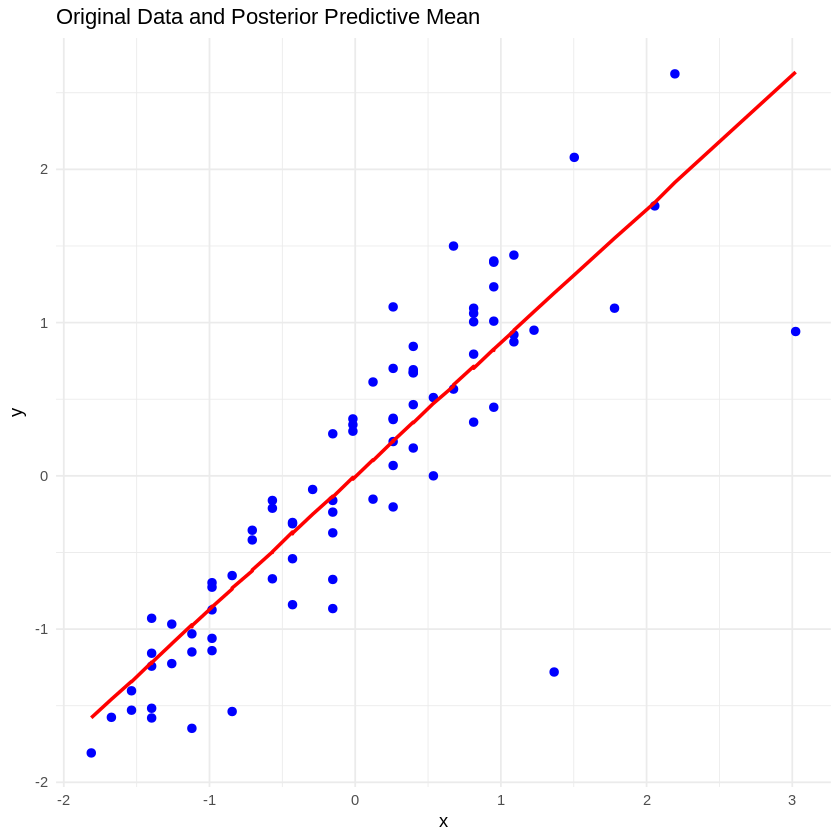

In [133]:
posterior_samples <- extract(model_fit)
y_pred_samples <- posterior_samples$osmo_pred
y_pred_mean <- apply(y_pred_samples, 2, mean)

# Plot the original data and the predicted values
ggplot(data.frame(x = gravity, y = osmo, y_pred = y_pred_mean), aes(x = x)) +
  geom_point(aes(y = y), color = "blue", size = 2) +
  geom_line(aes(y = y_pred), color = "red", size = 1) +
  labs(title = "Original Data and Posterior Predictive Mean",
       x = "x", y = "y") +
  theme_minimal()

The results look good, though it's clear that a couple of outliers have significant influence. Just for fun, let's assume that we want a model more robust to such outliers. For that, we can simply use a distributiion with wider tails, as it allocates more mass to the possibility of 'outliers'. Changing the above to assume t-distributed noise only involves changing a couple of lines in the <code>stan</code> code (since we're not setting priors). To make things simple, we'll deterministically set the degrees of freedom parameter (nu) to 3.

Instead of the line:

- <code>osmo ~ normal(alpha + beta * gravity, sigma);</code>

we now have:

- <code>osmo ~ student_t(3, alpha + beta * gravity, sigma);</code>

and instead of the line:

- <code>osmo_pred[n] = normal_rng(alpha + beta * gravity[n], sigma);</code>

we now have:

- <code>osmo_pred[n] = student_t_rng(3, alpha + beta * gravity[n], sigma);</code>

In [134]:
stan_code <- "
data {
  int<lower=0> N;
  vector[N] gravity;
  vector[N] osmo;
}

parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;

    real alpha_mu;
    real alpha_sigma;
    real beta_mu;
    real beta_sigma;
    real<lower=0> sigma_mu;
    real sigma_sigma;
}

model {
    // Priors
    alpha ~ normal(alpha_mu, alpha_sigma);
    beta ~ normal(beta_mu, beta_sigma);
    sigma ~ normal(sigma_mu, sigma_sigma);

    // Likelihood
    osmo ~ student_t(3, alpha + beta * gravity, sigma);
}

generated quantities {
  vector[N] osmo_pred;
  for (n in 1:N)
    osmo_pred[n] = student_t_rng(3, alpha + beta * gravity[n], sigma);
}
"

In [ ]:
gravity <- c(scale(as.vector(as.matrix(data$gravity))))
osmo <- c(scale(as.vector(as.matrix(data$osmo))))

N <- nrow(data)
data_list <- list(N=N, gravity=gravity, osmo=osmo)
model_fit <- stan(model_code = stan_code, data = data_list, warmup = 1000,
                 iter = 5000, chains = 4, refresh = 0, cores = 4)

Now we'll plot the results.

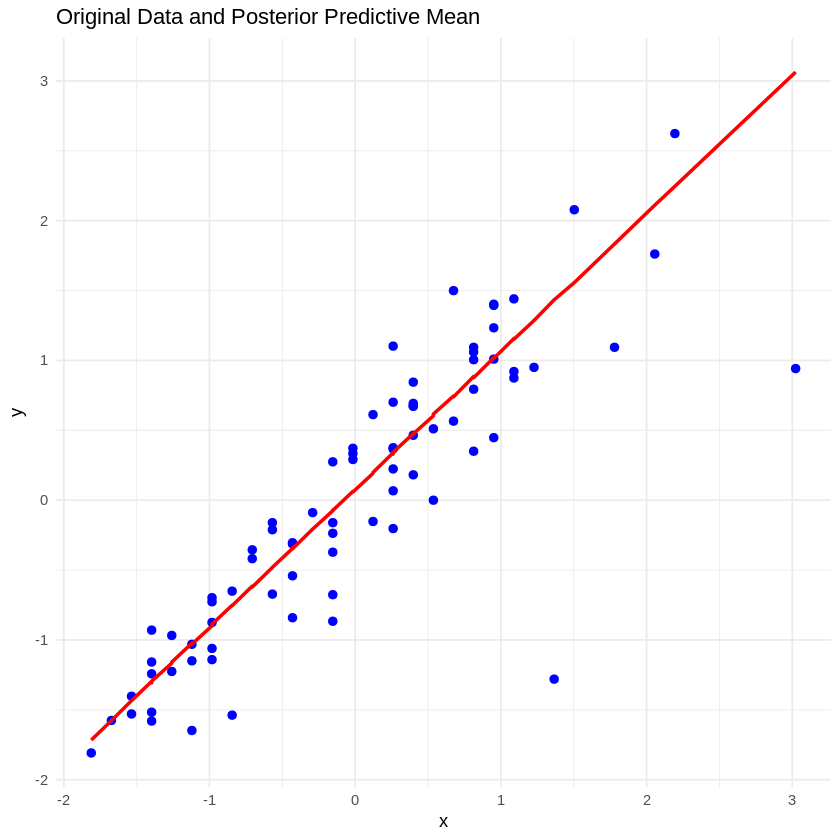

In [136]:
posterior_samples <- extract(model_fit)
y_pred_samples <- posterior_samples$osmo_pred
y_pred_mean <- apply(y_pred_samples, 2, mean)

# Plot the original data and the predicted values
ggplot(data.frame(x = gravity, y = osmo, y_pred = y_pred_mean), aes(x = x)) +
  geom_point(aes(y = y), color = "blue", size = 2) +
  geom_line(aes(y = y_pred), color = "red", size = 1) +
  labs(title = "Original Data and Posterior Predictive Mean",
       x = "x", y = "y") +
  theme_minimal()

You can see that the slope line pays little mind to the outliers.

# Putting it All Together